In [1]:
import os
import sys
os.environ['OMP_NUM_THREADS'] = '1'
#os.environ["THEANO_FLAGS"] = "device=gpu"
sys.path.append(os.getcwd()+"/..")
import lasagne
import theano.tensor as T
import theano
from tasks import check
from scripts import manifold
from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imsave

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from image_scatter import image_scatter
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np

from helpers import salt_and_pepper
def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, max(len(inputs) - batchsize + 1, len(inputs)), batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Couldn't import dot_parser, loading of dot files will not be possible.


## load model

In [3]:
v = check(
    what="notebook", 
    filename="../out/model.pkl",
    force_w=28,
    force_h=28,
    dataset="digits"
)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 28, 28)
Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 100000, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': u'adadelta'}
{'seed': 2}


In [4]:
capsule, data, layers, w, h, c = v

In [8]:
X = T.tensor4()
encode = theano.function([X], L.get_output(layers['hid1'], X))

## viz features

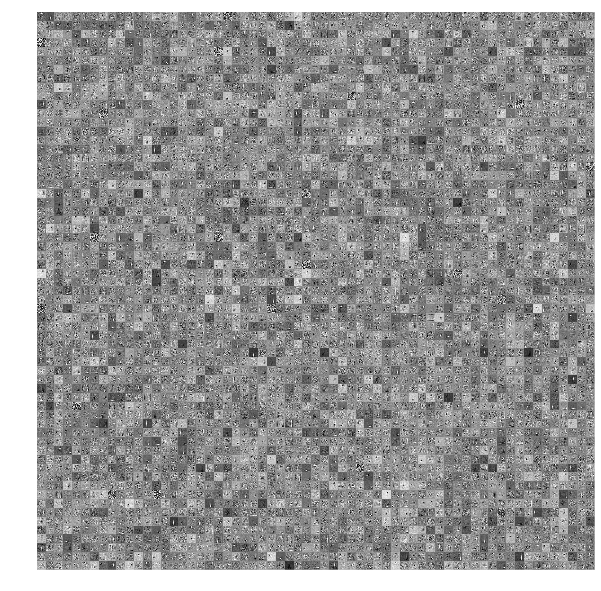

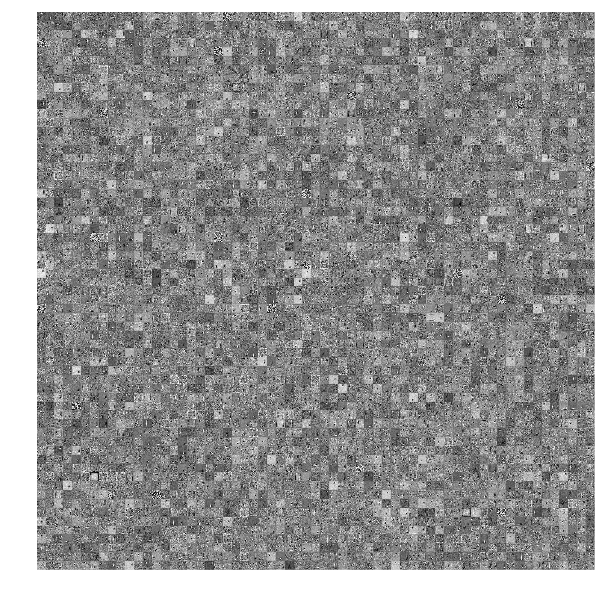

In [9]:
for name, layer in layers.items():
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2:
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            a, b = w, h
        else:
            W = W.reshape((W.shape[0]*W.shape[1], W.shape[2], W.shape[3]))
            a, b = W.shape[1:]
        fig = plt.figure(figsize=(10, 10))
        s = int(np.sqrt(W.shape[0]))
        plt.axis('off')
        img=tile_raster_images(W, (a, b), (s, s))
        plt.imshow(img, cmap="gray", interpolation='none')
        plt.show()

## iterative refinement

In [24]:
seed = 42
np.random.seed(seed)
N = 100
s = np.random.uniform(0, 1, size=(N, c, w, h))
s = s.astype(np.float32)
samples = []
samples.append(s.copy()[None, :, :, :, :])
nb_iter = 60
loss = []
for i in tqdm(range(nb_iter)):
    sprev = s  
    #s = s > 0.6
    s = s + (capsule.reconstruct(s) - s)
    s = s.astype(np.float32)
    samples.append(s.copy()[None, :, :, :, :])
    #s = np.random.binomial(n=1, p=s, size=s.shape).astype('float32')# binarize by sampling
    #s = s > 0.5
    score = np.abs(s - sprev).sum()
    loss.append(score)
samples = np.concatenate(samples, axis=0)
print(samples.shape)
print(loss)

(61, 100, 1, 28, 28)
[22646.809, 4194.2632, 2619.2766, 2055.0188, 1935.2389, 2117.0686, 2469.4141, 2776.6575, 2845.0234, 2672.5576, 2412.6626, 2196.5999, 2050.4697, 1938.0742, 1808.4377, 1664.9238, 1502.5831, 1337.7809, 1185.7559, 1031.0846, 883.78278, 755.47809, 621.12036, 511.48367, 452.3399, 405.67535, 373.01892, 328.14795, 291.03976, 272.30237, 242.80199, 234.11078, 220.09261, 192.05832, 178.24823, 162.77884, 158.13638, 150.69673, 146.55774, 139.33821, 131.07106, 121.60829, 116.9357, 108.78043, 93.273758, 81.457527, 75.724304, 70.145111, 66.131485, 65.173996, 65.505859, 64.217163, 63.969627, 62.426723, 59.628002, 58.023487, 55.593983, 54.362465, 55.3503, 55.896858]


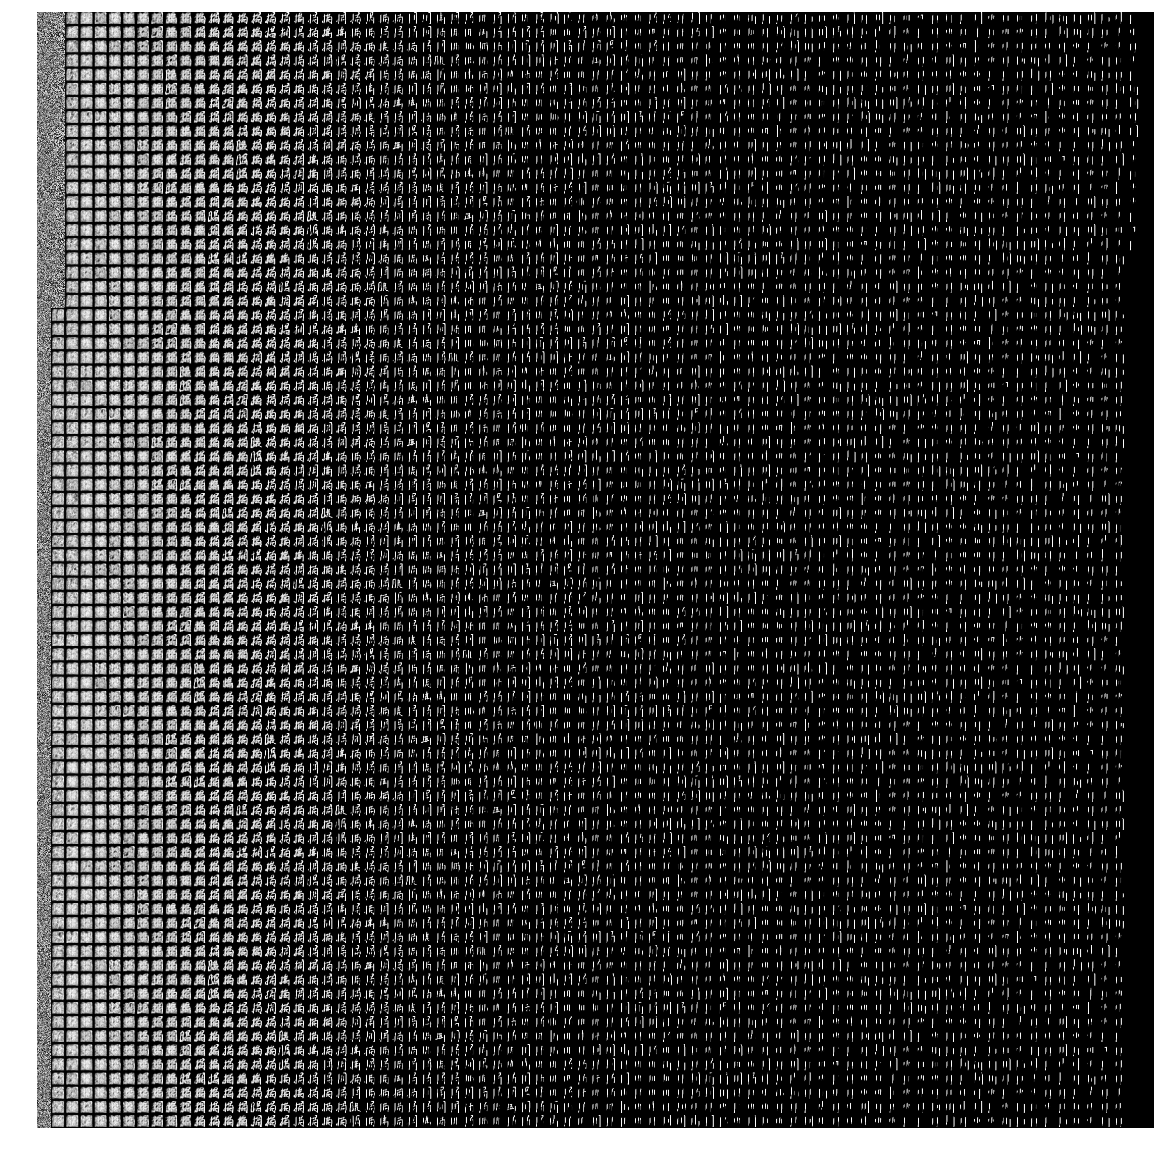

In [25]:
fig = plt.figure(figsize=(20, 20))
sw, sh = samples.shape[0:2]
samples_ = samples.copy()
samples_ = samples_.reshape((sw*sh, c, w, h))
samples_ = samples_.transpose((0, 2, 3, 1))
samples_ = samples_ * np.ones((1, 1, 1, 3))
img = dispims_color(samples_)
imsave('out.png', img)
plt.imshow(img)
plt.axis('off')
plt.show()

In [26]:
hid = []
d = []
for i in range(10):
    d.append(capsule.preprocess(data.X).transpose((0, 2 ,3 , 1))  * np.ones((1, 1, 1, 3)))
    hid.append(encode(capsule.preprocess(data.X)))

d = np.concatenate(d, axis=0)
hid = np.concatenate(hid, axis=0)

In [27]:
#mf = IncrementalPCA(n_components=2, batch_size=1024)
mf = PCA(n_components=2)
#mf = TSNE(n_components=2, verbose=1)
h2d = mf.fit_transform(hid)

In [28]:
mf = PCA(n_components=2)
#mf = IncrementalPCA(n_components=2, batch_size=1024)
#mf = TSNE(n_components=2, verbose=1)
d2d = mf.fit_transform(d.reshape(d.shape[0], -1))

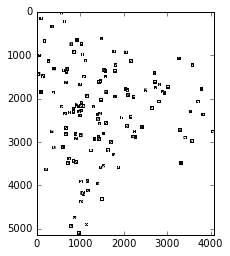

In [29]:
img = image_scatter(h2d, d, 80)
imsave('out_scatter.png', img)
plt.imshow(img, cmap='gray')
plt.show()

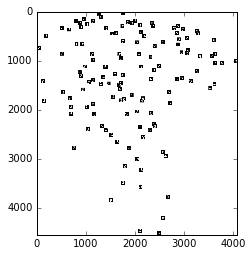

In [30]:
img = image_scatter(d2d, d, 80)
imsave('out_scatter_data.png', img)
plt.imshow(img, cmap='gray')
plt.show()

## transferability

In [31]:
from lasagnekit.datasets.mnist import MNIST

In [36]:
mnist = MNIST()
mnist.load()
X_transf_orig = mnist.X.reshape((mnist.X.shape[0], c, w, h))
X_transf_orig = X_transf_orig[mnist.y==8]
X_transf_orig = X_transf_orig[0:500]

In [66]:
X_transf_rec = X_transf_orig.copy().astype(np.float32)
X_transf_rec = X_transf_rec
imgs = []
for i in range(100):
    X_transf_rec = X_transf_rec + 0.1 * (capsule.reconstruct(X_transf_rec) - X_transf_rec)
    imgs.append(X_transf_rec.copy())
    print(((X_transf_rec - capsule.reconstruct(X_transf_rec))**2).sum(axis=(1, 2, 3)).mean())

7.93458
7.33977
6.81303
6.34537
5.92932
5.55841
5.22741
4.93003
4.66285
4.42212
4.20451
4.00695
3.82693
3.6618
3.50956
3.3681
3.23508
3.10962
2.99112
2.87841
2.77076
2.66757
2.56858
2.47353
2.38312
2.29683
2.21468
2.13665
2.06231
1.99163
1.92415
1.85947
1.797
1.73618
1.67735
1.62054
1.56595
1.51369
1.46368
1.41571
1.36934
1.3247
1.28164
1.23992
1.19971
1.16104
1.12404
1.08875
1.05508
1.02307
0.99272
0.963825
0.936073
0.909258
0.883283
0.858191
0.834063
0.810922
0.788761
0.767661
0.747755
0.728966
0.711258
0.694207
0.677431
0.660848
0.644335
0.627954
0.61173
0.595761
0.580126
0.564856
0.549929
0.535444
0.521433
0.507759
0.494417
0.481344
0.468584
0.45613
0.443926
0.432089
0.420762
0.410096
0.40013
0.39076
0.381866
0.373296
0.36486
0.356476
0.348088
0.339707
0.331474
0.323463
0.315777
0.30845
0.301441
0.294749
0.288383
0.28233


In [70]:
from scripts import imgtovideo
imgtovideo.imgs_to_video(imgs, out='out.mp4')

ValueError: Invalid number of channels in image array.

In [62]:
X_transf = X_transf_orig.transpose((0, 2, 3, 1))
X_transf = X_transf * np.ones((1, 1, 1, 3))

X_transf_rec = X_transf_rec.transpose((0, 2, 3, 1))
X_transf_rec = X_transf_rec * np.ones((1, 1, 1, 3))

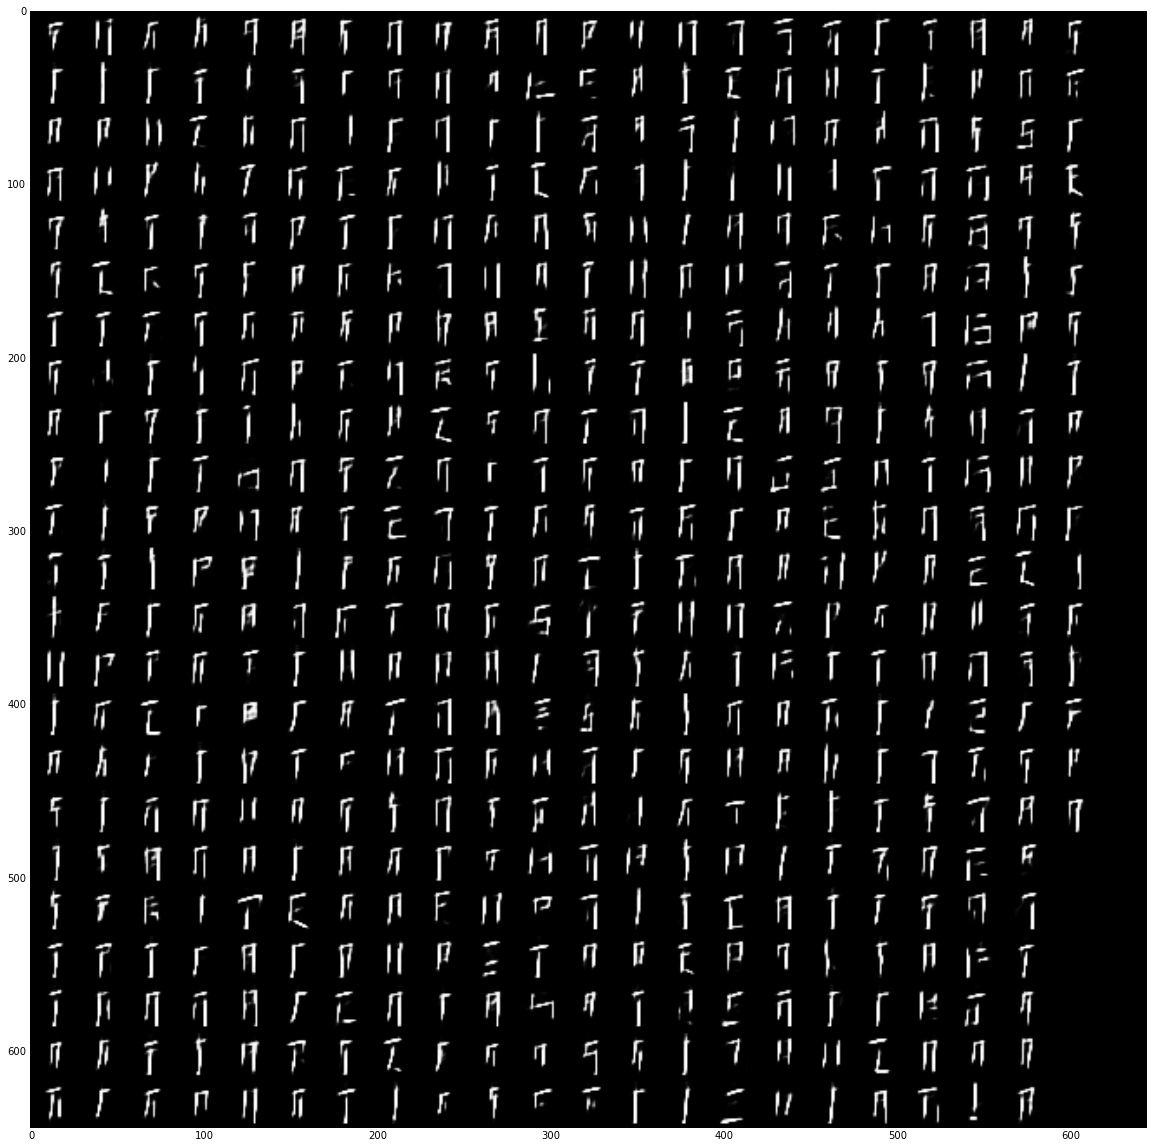

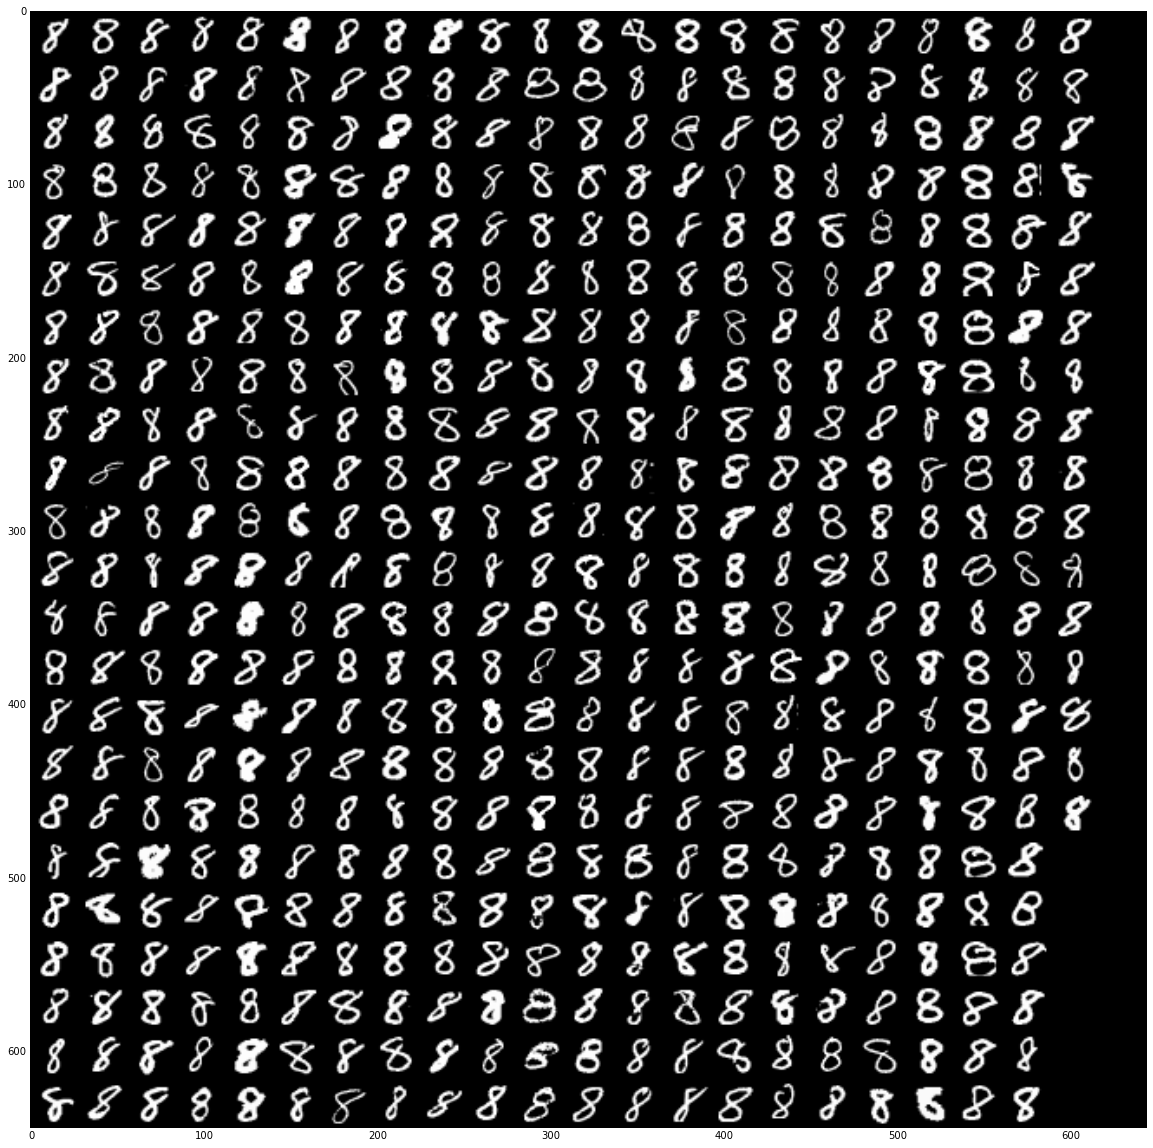

In [63]:
fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_transf_rec[0:500])
plt.imshow(img, cmap='gray')
plt.show()
fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_transf[0:500])
plt.imshow(img, cmap='gray')
plt.show()